In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
train = pd.read_csv(r'dataset/mitbih_train.csv', header=None)
test = pd.read_csv(r'dataset/mitbih_test.csv', header=None)

In [29]:
train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [4]:
train[187]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float64

# data preparation

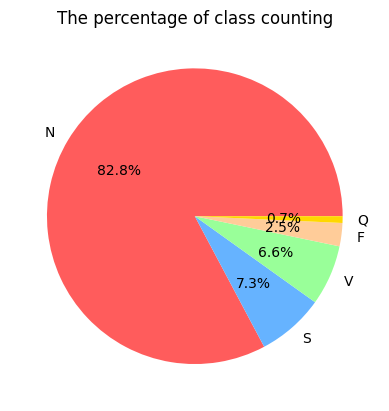

In [30]:
# Count values
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('The percentage of class counting')
plt.show()

In [31]:
random_seed = 0
df_0=(train[train[187]==0]).sample(n=20000,random_state=42)
df_1=train[train[187]==1]
df_2=train[train[187]==2]
df_3=train[train[187]==3]
df_4=train[train[187]==4]


df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=random_seed+1)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=random_seed+2)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=random_seed+3)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=random_seed+4)

train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

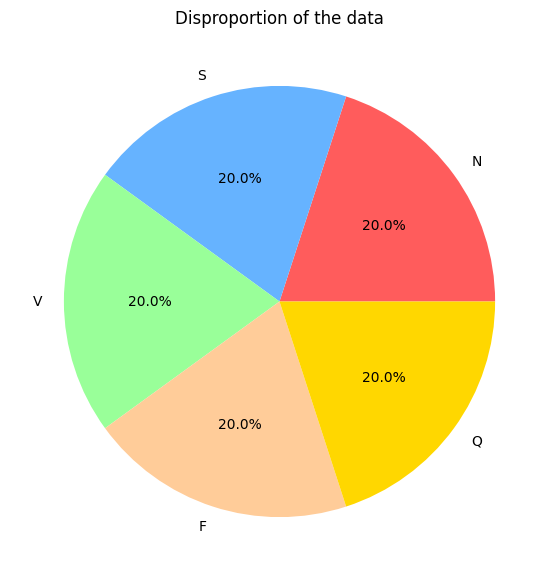

In [32]:
plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Disproportion of the data')
plt.show()

In [33]:
X_train, y_train = train.iloc[:, :187], train[187]
X_test, y_test = test.iloc[:, :187], test[187]

In [34]:
print(X_train)

            0         1         2         3         4         5         6    \
10153  0.162791  0.540698  0.755814  0.186047  0.168605  0.546512  0.616279   
33886  0.990066  0.938742  0.344371  0.034768  0.273179  0.331126  0.326159   
32005  0.974239  0.932084  0.590164  0.131148  0.014052  0.168618  0.238876   
56159  0.978495  0.723118  0.526882  0.298387  0.220430  0.158602  0.091398   
61783  0.963351  0.709424  0.060209  0.013089  0.057592  0.041885  0.047120   
...         ...       ...       ...       ...       ...       ...       ...   
85772  0.737909  0.636505  0.536661  0.416537  0.288612  0.166927  0.099844   
84168  0.932118  0.879433  0.817629  0.743668  0.644377  0.519757  0.400203   
83402  0.952941  0.631373  0.670588  0.670588  0.670588  0.643137  0.631373   
83630  1.000000  0.816384  0.500000  0.228814  0.104520  0.064972  0.096045   
81185  0.960784  0.509804  0.533333  0.560784  0.560784  0.564706  0.568627   

            7         8         9    ...  177  178 

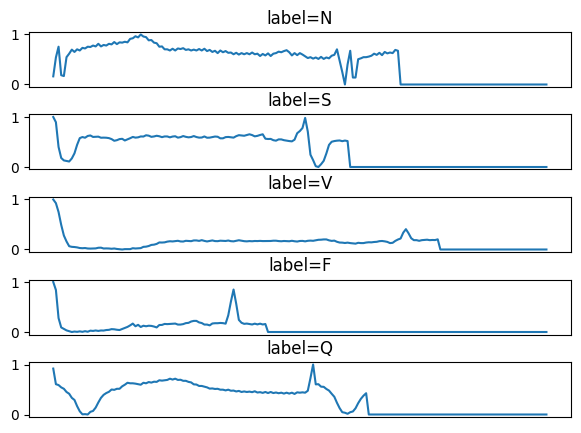

In [35]:
labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,1, figsize=(7,5), gridspec_kw={'hspace': 0.5})
for i in range(5):
    ax[i].plot(X_train[y_train==i].iloc[0])
    ax[i].set_title(f'label={labels[i]}')
    ax[i].set_xticks([])

In [36]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_train_norm = standard_scaler.transform(X_train)
X_test_norm = standard_scaler.transform(X_test)

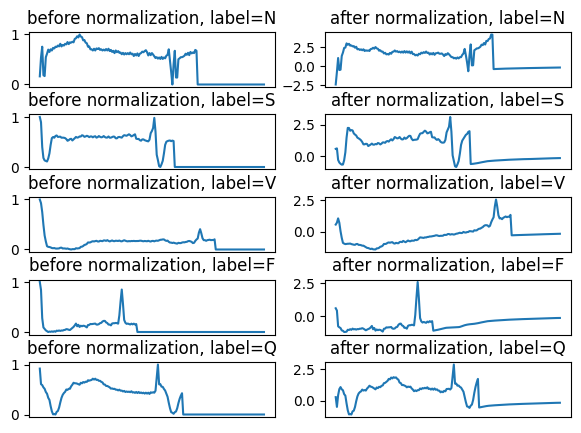

In [37]:
fig, ax = plt.subplots(5,2, figsize=(7,5), gridspec_kw={'hspace': 0.5})
for i in range(5):
    ax[i][0].plot(X_train[y_train==i].iloc[0])
    ax[i][1].plot(X_train_norm[y_train==i][0])
    ax[i][0].set_title(f'before normalization, label={labels[i]}')
    ax[i][0].set_xticks([])
    ax[i][1].set_xticks([])
    ax[i][1].set_title(f'after normalization, label={labels[i]}')

In [38]:
def getXy(df):
    X = df.drop(187, axis=1)
    y = df[187]
    return X, y

getXy(train)

(            0         1         2         3         4         5         6    \
 10153  0.162791  0.540698  0.755814  0.186047  0.168605  0.546512  0.616279   
 33886  0.990066  0.938742  0.344371  0.034768  0.273179  0.331126  0.326159   
 32005  0.974239  0.932084  0.590164  0.131148  0.014052  0.168618  0.238876   
 56159  0.978495  0.723118  0.526882  0.298387  0.220430  0.158602  0.091398   
 61783  0.963351  0.709424  0.060209  0.013089  0.057592  0.041885  0.047120   
 ...         ...       ...       ...       ...       ...       ...       ...   
 85772  0.737909  0.636505  0.536661  0.416537  0.288612  0.166927  0.099844   
 84168  0.932118  0.879433  0.817629  0.743668  0.644377  0.519757  0.400203   
 83402  0.952941  0.631373  0.670588  0.670588  0.670588  0.643137  0.631373   
 83630  1.000000  0.816384  0.500000  0.228814  0.104520  0.064972  0.096045   
 81185  0.960784  0.509804  0.533333  0.560784  0.560784  0.564706  0.568627   
 
             7         8         9    

# Evaluation

In [ ]:
#define architecture
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        self.conv0 = nn.Conv1d(in_channels, out_channels, kernel_size=5, stride=1, padding='same', bias=False)
        self.relu0 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv1d(out_channels, out_channels, kernel_size=5, stride=1, padding='same', bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.pooling = nn.MaxPool1d(5, stride=2)

    def forward(self, x):
        out = self.conv0(x)
        out = self.relu0(out)
        out = self.conv1(out)
        out += x
        out = self.relu1(out)
        out = self.pooling(out)
        return out
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5),
            Block(64,64),
            Block(64,64),
            Block(64,64),
            Block(64,64),
            Block(64,64)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,5),
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = nn.Flatten()(x)
        x = self.fc_layer(x)
        return x

In [ ]:
class ECG(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        X = self.X.iloc[idx].values[None, ...]
        y = self.y.iloc[idx]
        return X, y
    
    def __len__(self):
        return len(self.y)

In [ ]:
train_loader = DataLoader(ECG(X=X_train, y=y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(ECG(X=X_test, y=y_test), batch_size=32, shuffle=False)

In [ ]:
next(iter(train_loader))

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [43]:
# define train function  
class Training():
    def __init__(self, model, train_loader, test_loader, epochs , criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs

        self.train_loader = DataLoader(ECG(X=X_train, y=y_train), batch_size=32, shuffle=True)
        self.test_loader = DataLoader(ECG(X=X_test, y=y_test), batch_size=32, shuffle=False)

    def train(self):
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(self.train_loader):
                # print(inputs)
                inputs, labels = inputs.float().to(self.device), labels.long().to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs).float()

                loss = self.criterion(outputs, labels)
                loss.backward()

                self.optimizer.step() 
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_loss.append(running_loss/len(self.train_loader))
            train_acc.append(100.*correct/total)

            self.model.eval()
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in tqdm(self.test_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs).float()
                    loss = self.criterion(outputs, labels)
                    running_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            test_loss.append(running_loss/len(self.test_loader))
            test_acc.append(100.*correct/total)

            print(f'Epoch: {epoch+1}/{epoch}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_acc[-1]:.2f}%')


        return train_loss, train_acc, test_loss, test_acc



In [ ]:
x = Training(
    model=model,
    train_loader=train_loader, test_loader=test_loader,
    epochs=1, criterion=criterion,
    optimizer=optimizer, device=device
)
x.train()

In [42]:
torch.load('/home/jerry/code/MLmedicine/lab1/output/best.pth')

OrderedDict([('conv_layer.0.weight',
              tensor([[[ 0.0654,  0.3348,  0.3943,  0.0586, -0.2474]],
              
                      [[ 0.3353,  0.1017, -0.2844, -0.2179,  0.0812]],
              
                      [[ 0.1741, -0.3198, -0.1636,  0.2701,  0.1792]],
              
                      [[-0.4484, -0.4509, -0.3964,  0.3889, -0.1154]],
              
                      [[ 0.2429,  0.1505,  0.2727,  0.2416,  0.1435]],
              
                      [[ 0.1622, -0.3432,  0.3558,  0.4156,  0.0767]],
              
                      [[-0.0368,  0.3064,  0.2493, -0.3461, -0.2421]],
              
                      [[ 0.4644, -0.1902, -0.3379,  0.0678, -0.0497]],
              
                      [[ 0.5452, -0.3496, -0.1645, -0.1702, -0.3737]],
              
                      [[-0.4925,  0.0857,  0.4059, -0.2422, -0.4425]],
              
                      [[ 0.3797, -0.0334, -0.0904,  0.1539, -0.2799]],
              
                 